# Exoplanets

This dataset comes from the NASA Exoplanet Archive and lists most of the known exoplanets and their characteristics

Source : https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS

Columns description : https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html

In [397]:
from datetime import datetime
from sys import getsizeof

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [398]:
df = pd.read_csv('exo_ds.csv', on_bad_lines='skip', low_memory=False)

## Functions
Some useful functions for the analysis of this dataset

In [399]:
def perc(total, partial, rnd=2):
    """ Function to calculate the percentage represented 
    by a partial value on a total value 
    total : type <number>
    partial : type <number>
    rnd : type <number>
    """

    x = (partial / total) * 100

    return round(x, rnd)

In [400]:
def perc_var(start, end, rnd=2):
    """ Function to calculate the variation between 
    an initial (start) and final (end) value in percentage
    start : type <number>
    end : type <number>
    rnd : type <number> 
    """

    variation = ((end - start) / start) * 100

    return round(variation, rnd)

In [401]:
def mem(obj, unit='KB', rnd=2):
    """ Function returning the memory size of an object 
    obj : type <object>
    unit : type <str> ['B', 'KB', 'MB']
    rnd : type <number>  
    """
    if unit == 'B':
        obj_mem = getsizeof(obj)
    elif unit == 'KB':
        obj_mem = getsizeof(obj) / 1000
    elif unit == 'MB':
        obj_mem = getsizeof(obj) / 1000000
    else:
        raise ValueError("Wrong inputs, please check docstring")
    
    return round(obj_mem, rnd)

In [402]:
def nan(col, df=None, show_more = False):
    """ This function allows to know the integrity 
    level of a given column in a Dataframe or in a Series. 
    It returns in a tuple the number of no-NaN rows 
    as well as its percentage represented.
    
    If a Pandas dataframe has been entered as a parameter 
    (df=pandas.core.frame.DataFrame) then 'col' must be the 
    desired column name (col=string)

    If no dataframe has been entered (df=None) 
    then 'col' must be a Pandas Series
    (col=pandas.core.series.Series)

    The 'show_more' parameter (boolean) allows to display 
    additional information such as the amount of 
    NaN data and the total number of rows :
    False -> return (no-NaN rows, integrity %)
    True -> return (no-NaN rows, integrity %, NaN rows, total rows)
    """

    if isinstance(df, pd.core.frame.DataFrame):
        rows = df.shape[0]
        nan = df[col].isna().sum()
        ok = df.shape[0] - nan
        integrity = round(perc(rows, ok), 3)
    
    elif isinstance(col, pd.core.series.Series):
        rows = col.shape[0]
        nan = col.isna().sum()
        ok = col.shape[0] - nan
        integrity = round(perc(rows, ok), 3)
    
    else:
        raise TypeError('WRONG INPUTS IN PARAMETERS')
        
    if not show_more:
        return (ok, integrity)

    else:
        return (ok, integrity, nan, rows)

In [403]:
def date_minmax(col, df=None, fmt='%Y-%m-%d', mode='max', debug=False):
    """ Returns the earliest or latest date of a column
    from a Pandas dataframe or from a Pandas Series 
    
    If a dataframe has been entered as a parameter 
    (df=pandas.core.frame.DataFrame) then 'col' must be the 
    desired column name (string)
    
    If no dataframe has been entered (df=None) 
    then 'col' must be a Pandas Series

    The default date format on which the function 
    is based is '%Y-%m-%d' but this can be changed 
    using the 'fmt' parameter

    The 'mode' parameter can have two states :
    - 'max' : (default) Returns the most recent date
    - 'min' : Returns the earliest date
    """
    errors = 0

    if isinstance(df, pd.core.frame.DataFrame):
        datetime_list = []
        for date in df[col]:
            try:
                datetime_list.append(datetime.strptime(date, fmt))
            except TypeError:
                errors+=1
                continue
            except ValueError:
                errors+=1
                continue

    elif isinstance(col, pd.core.series.Series):
        datetime_list = []
        for date in col:
            try:
                datetime_list.append(datetime.strptime(date, fmt))
            except TypeError:
                errors+=1
                continue
            except ValueError:
                errors+=1
                continue
    
    else:
        raise TypeError('WRONG INPUTS IN PARAMETERS')

    if debug and errors > 0:
        print(f"{errors} rows have been ignored due to errors")

    if mode == 'max':
        return max(datetime_list)
    else:
        return min(datetime_list)

In [404]:
def to_df(series, label_idx='index',
    label_val='values', frm=0, to=None):
    """ Transforms a Series into a Dataframe by allowing 
    to adjust several parameters:
    - label_idx : name of the index column
    - label_val : name of the values column
    - frm : index from which to display (default : 0)
    - to : limit index to display (default : last index [None])
    """

    if not isinstance(series, pd.core.series.Series):
        raise TypeError("Not a Pandas Series")

    series = series.iloc[frm:to]

    dtf = pd.DataFrame({
        label_idx:series.index,
        label_val:series.values})
    
    return dtf

In [405]:
def plot_counts(series, x_label='x', y_label='y', title='',
frm=0, to=None, output='img'):

    if frm != 0 or to != None:
        series = series[frm:to]

    x = series.index
    y = series.values

    fig = px.bar(
    x=x, 
    y=y, 
    title=title,
    labels={'x': x_label, 'y': y_label},
    text_auto='.2s'
    )

    if output == 'fig':
        return fig # pyplot object

    elif output == 'img' or output == 'bytes':

        fig.update_yaxes(
        showgrid=True,
        gridcolor='black',
        gridwidth=0.5
        )

        img = pio.to_image(
        fig, 
        format='png', 
        validate=True, 
        engine='orca'
        )

        if output == 'img':
            return Image(img) # Image
        else:
            return img # Image bytes
    
    else:
        raise TypeError('Wrong output parameter, please check the docstring')

## Exploration
A quick exploration of this dataset

In [406]:
df.shape

(33376, 121)

In [407]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33376 entries, 0 to 33375
Columns: 121 entries, rowid to pl_ntranspec;;;;;;
dtypes: float64(69), int64(24), object(28)
memory usage: 30.8+ MB


In [408]:
df.head(10)

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,default_flag,sy_snum,...,sy_kepmag,rowupdate,pl_pubdate,releasedate,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec;;;;;;
0,1,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,1,2,...,NaN,2014-05-14,2008-01,2014-05-14,2,1,2,0,0,0;;;;;;
1,2,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,0,2,...,NaN,2014-07-23,2011-08,2014-07-23,2,1,2,0,0,0;;;;;;
2,3,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,0,1,...,NaN,2018-04-25,2009-10,2014-05-14,0,1,1,0,0,0;;;;;;
3,4,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,0,1,...,NaN,2018-04-25,2011-08,2014-07-23,0,1,1,0,0,0;;;;;;
4,5,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,1,1,...,NaN,2018-09-04,2017-03,2018-09-06,0,1,1,0,0,0;;;;;;
5,6,14 And b,14 And,b,HD 221345,HIP 116076,TIC 333225860,Gaia DR2 1920113512486282240,1,1,...,NaN,2014-05-14,2008-12,2014-05-14,0,1,1,0,0,0;;;;;;
6,7,14 And b,14 And,b,HD 221345,HIP 116076,TIC 333225860,Gaia DR2 1920113512486282240,0,1,...,NaN,2014-07-23,2011-08,2014-07-23,0,1,1,0,0,0;;;;;;
7,8,14 Her b,14 Her,b,HD 145675,HIP 79248,TIC 219483057,Gaia DR2 1385293808145621504,0,1,...,NaN,2018-04-25,2004-01,2014-08-21,0,1,4,1,0,0;;;;;;
8,9,14 Her b,14 Her,b,HD 145675,HIP 79248,TIC 219483057,Gaia DR2 1385293808145621504,0,1,...,NaN,2021-09-20,2021-07,2021-09-20,0,1,4,1,0,0;;;;;;
9,10,14 Her b,14 Her,b,HD 145675,HIP 79248,TIC 219483057,Gaia DR2 1385293808145621504,0,1,...,NaN,2018-04-25,2008-04,2014-08-21,0,1,4,1,0,0;;;;;;


From the top of its 33376 rows and 121 columns, this dataset seems relatively large. 

Based on these first 10 lines, we notice that several planets are duplicated, for example '11 Com b' appears 3 times, which may explain the depth of the dataset. This problem should be addressed in the 'data cleaning' section.

We also notice that the last column seems to have a rather strange syntax: 'pl_ntranspec;;;;;;'. This is probably an error that will also have to be fixed in the Data Cleaning part

### Column descriptions

Not all of these 121 columns will be exploited here, but we will nevertheless try to provide a description of those that seem to us to be the most important.

The descriptions of all the columns we have chosen to keep are listed in the file *columns_description.md*

## Data Cleaning
Cleaning up superfluous data

Before starting the cleaning phase, let's keep a few parameters in mind in order to define later in what proportions the dataframe has been reduced

In [409]:
df_mem_before = mem(df, unit='MB')
df_shape_before = df.shape

### Duplicates

In [410]:
df.shape

(33376, 121)

At the date of August 1st 2022 more than 5000 exoplanets could be counted, however, the shape function seems to tell us that the dataset has 33376 lines

The reason for this is that this dataset has **several sets of parameters coming from various papers**, each of the exoplanets listed can therefore appear several times (one line for each paper published). Thus, the 33376 lines returned by the 'shape' function do not refer to the numbers of exoplanets recorded. 

To illustrate this, let us take as an example the planet WASP-39 b

In [411]:
wasp_39 = df.loc[df['pl_name'] == 'WASP-39 b']
wasp_39

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,default_flag,sy_snum,...,sy_kepmag,rowupdate,pl_pubdate,releasedate,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec;;;;;;
32771,32772,WASP-39 b,WASP-39,b,NaN,NaN,TIC 181949561,Gaia DR2 3643098875168270592,0,1,...,NaN,2019-03-18,2017-06,2019-03-21,0,0,2,0,2,636;;;;;;
32772,32773,WASP-39 b,WASP-39,b,NaN,NaN,TIC 181949561,Gaia DR2 3643098875168270592,0,1,...,NaN,2019-11-27,2018-05,2019-12-05,0,0,2,0,2,636;;;;;;
32773,32774,WASP-39 b,WASP-39,b,NaN,NaN,TIC 181949561,Gaia DR2 3643098875168270592,0,1,...,NaN,2016-04-27,2016-01,2016-04-28,0,0,2,0,2,636;;;;;;
32774,32775,WASP-39 b,WASP-39,b,NaN,NaN,TIC 181949561,Gaia DR2 3643098875168270592,0,1,...,NaN,2016-09-06,2016-08,2016-09-08,0,0,2,0,2,636;;;;;;
32775,32776,WASP-39 b,WASP-39,b,NaN,NaN,TIC 181949561,Gaia DR2 3643098875168270592,0,1,...,NaN,2022-08-09,2017-07,2022-08-09,0,0,2,0,2,636;;;;;;
32776,32777,WASP-39 b,WASP-39,b,NaN,NaN,TIC 181949561,Gaia DR2 3643098875168270592,0,1,...,NaN,2016-01-12,2016-01,2016-01-14,0,0,2,0,2,636;;;;;;
32777,32778,WASP-39 b,WASP-39,b,NaN,NaN,TIC 181949561,Gaia DR2 3643098875168270592,0,1,...,NaN,2015-01-08,2015-02,2015-01-08,0,0,2,0,2,636;;;;;;
32778,32779,WASP-39 b,WASP-39,b,NaN,NaN,TIC 181949561,Gaia DR2 3643098875168270592,0,1,...,NaN,2016-10-12,2017-01,2016-10-13,0,0,2,0,2,636;;;;;;
32779,32780,WASP-39 b,WASP-39,b,NaN,NaN,TIC 181949561,Gaia DR2 3643098875168270592,1,1,...,NaN,2014-05-14,2011-07,2014-05-14,0,0,2,0,2,636;;;;;;


We can see that the planet appears 9 times under different publications, at different dates

The dataset presents nevertheless a column named 'default_flag' which indicates (by boolean value) the reference exoplanet among those duplicated. For this planet it seems that the 2011 publication is set as default entry.

In [412]:
# Display of the 3 columns that interest us
wasp_39[['pl_name', 'default_flag', 'pl_pubdate']]

,pl_name,default_flag,pl_pubdate
32771,WASP-39 b,0,2017-06
32772,WASP-39 b,0,2018-05
32773,WASP-39 b,0,2016-01
32774,WASP-39 b,0,2016-08
32775,WASP-39 b,0,2017-07
32776,WASP-39 b,0,2016-01
32777,WASP-39 b,0,2015-02
32778,WASP-39 b,0,2017-01
32779,WASP-39 b,1,2011-07


We will use the boolean values of the 'default_flag' column to remove duplicate planets from the dataframe, keeping only those with a value of 1.

(1) We will first sort all rows in descending order based on the 'default_flag' column, so that all '1's appear first, then we use the 'drop_duplicate' function on the 'pl_name' column which, by default, keeps only the first occurrence of the duplicated  (taking care to reset the index). At this point, all duplicate planets have already been deleted, leaving only those with a True default_flag

(2) Finally, we decide to sort the dataset alphabetically by 'pl_planet'

In [413]:
# 1
df = df.sort_values('default_flag', ascending=False).drop_duplicates('pl_name').reset_index()

# 2
df = df.sort_values('pl_name').reset_index()

df[['pl_name', 'default_flag', 'pl_pubdate']]

,pl_name,default_flag,pl_pubdate
0,11 Com b,1,2008-01
1,11 UMi b,1,2017-03
2,14 And b,1,2008-12
3,14 Her b,1,2022-09
4,16 Cyg B b,1,2017-03
...,...,...,...
5182,ups And b,1,2011-01
5183,ups And c,1,2011-01
5184,ups And d,1,2011-01
5185,ups Leo b,1,2021-12


This deletion of duplicates makes us go directly from a dataset of 33376 lines to 5187 lines, which represents a loss of about 84% but brings us closer to the total number of exoplanets known to date.

### Columns

#### Last column syntax
Let's start with the last column which seemed to have a strange syntax

In [414]:
(df.columns[-1], nan(df.columns[-1], df=df))

('pl_ntranspec;;;;;;', (5187, 100.0))

This column refers to 'pl_ntranspec' which denotes the number of literature spectra available for the host star in NASA's exoplanet archive.

Since the column has full integrity, it will not be deleted but only renamed first of all

In [415]:
# Renaming the column
df = df.rename(columns={'pl_ntranspec;;;;;;' : 'pl_ntranspec'})
df.columns[-1]

'pl_ntranspec'

This being done, it turns out that 'pl_ntranspec' column data also has the same syntax problem, let's see :

In [416]:
df['pl_ntranspec']

0       0;;;;;;
1       0;;;;;;
2       0;;;;;;
3       0;;;;;;
4       0;;;;;;
         ...   
5182    0;;;;;;
5183    0;;;;;;
5184    0;;;;;;
5185    0;;;;;;
5186    0;;;;;;
Name: pl_ntranspec, Length: 5187, dtype: object

The idea would be to get all the inappropriate syntaxes from the column to keep only the digits

In [417]:
import re

def clean(x):
    x = x.replace(';', '')
    return(int(x))

df['pl_ntranspec'] = df['pl_ntranspec'].apply(clean)
df['pl_ntranspec']

0       0
1       0
2       0
3       0
4       0
       ..
5182    0
5183    0
5184    0
5185    0
5186    0
Name: pl_ntranspec, Length: 5187, dtype: int64

#### Columns integrity
There are 123 columns in this dataset, but do they all have a satisfactory level of integrity? Let's see by using our 'nan' function coded above.

In [418]:
integ_list = []

# We pass each column name to the 'nan' function
for name in df.columns:
    nan_res = nan(name, df=df)
    integ_list.append((name, nan_res[0], nan_res[1]))

integ_df = pd.DataFrame(integ_list, columns=['column name', 'integrity val', 'integrity rate'])

In [419]:
integ_df.describe()

,integrity val,integrity rate
count,123.000000,123.000000
mean,3672.373984,70.799431
std,1922.803769,37.069658
min,9.000000,0.170000
25%,1561.500000,30.105000
50%,5018.000000,96.740000
75%,5187.000000,100.000000
max,5187.000000,100.000000


The describe function tells us that the average integrity rate of the columns is 70%, i.e. each column has on average 70% of non-empty data, which is rather satisfactory. However, we notice that at least one column has a relatively low integrity rate (0.17%), we will have to check if other columns are concerned. But before, let's refine these results with a code that allows us to know the integrity of the columns by more precise levels

In [420]:
integ_list = []
cols = len(df.columns)
for ten in range(10, 110, 10):
    lim = len(integ_df.loc[integ_df['integrity rate'] >= ten])
    lim_rate = perc(cols, lim)
    integ_list.append((ten, lim_rate, 100-lim_rate))

integ_more_df = pd.DataFrame(integ_list, columns=['integrity target (rate >=)', 'columns concerned (rate)', 'columns not concerned (rate)'])
integ_more_df.style.set_caption('Analysis by integrity rate bands')

,integrity target (rate >=),columns concerned (rate),columns not concerned (rate)
0,10,93.500000,6.500000
1,20,79.670000,20.330000
2,30,74.800000,25.200000
3,40,72.360000,27.640000
4,50,68.290000,31.710000
5,60,66.670000,33.330000
6,70,63.410000,36.590000
7,80,60.980000,39.020000
8,90,55.280000,44.720000
9,100,41.460000,58.540000


These results tell us that :
- The vast majority of columns have a good integrity rate, this seems to be a good basis for visualizing future statistics :
  - just over 41% of the columns have full integrity 
  - more than 60% have an integrity rate of 80% or higher.
- There are still more than 6% of the columns that have an integrity rate less than or equal to 10%.

In [421]:
# Integrity rate below 1%
low_col = integ_df.loc[integ_df['integrity rate'] <= 1].sort_values(by='integrity rate').reset_index()
low_col

,index,column name,integrity val,integrity rate
0,67,pl_trueobliq,9,0.17
1,62,pl_occdep,18,0.35
2,111,sy_icmag,19,0.37
3,66,pl_projobliq,42,0.81
4,44,pl_cmasse,43,0.83
5,45,pl_cmassj,43,0.83


There are a total of 6 columns in this dataset that have an integrity rate below 1%

In [422]:
df.shape

(5187, 123)

In [423]:
df = df.drop(low_col['column name'], axis=1)

In [424]:
df.shape

(5187, 117)

### Mass

Let's see if there are other mass-related data worth cleaning up (other than 'pl_cmass' and 'pl_cmassj').

There are several methods to estimate the mass of an exoplanet, and each of these techniques has its own column :

- 'pl_msinie' / 'pl_msinij' are planet masses **determined by radial velocity variations of the host star** of the system.
 
- 'pl_mass' / 'pl_massj' represent masses **determined by techniques targeting the planet** itself (amount and density of matter etc). 

- 'pl_bmass' and 'pl_bmassj' do not refer to a new measurement technique but simply **retrieve the best mass among those available** (i.e. 'pl_mass' or 'pl_msini')

*Reminder : the columns 'pl_cmassj' and 'pl_cmasse' have been removed above for their low integrity rate*

#### Integrity of mass-related columns

We can start by determining the integrity level of each of these columns.

In [425]:
mass_col = [
    'pl_masse', 
    'pl_massj', 
    'pl_msinie', 
    'pl_msinij', 
    'pl_bmasse', 
    'pl_bmassj'
    ]

integ_list = []

for name in mass_col:
    integrity = nan(name, df=df)
    integ_list.append((name, integrity[0], integrity[1]))

integ_df = pd.DataFrame(integ_list, columns=['column name', 'integrity val', 'integrity rate'])
integ_df.style.set_caption('Integrity of mass-related columns')

,column name,integrity val,integrity rate
0,pl_masse,1362,26.260000
1,pl_massj,1362,26.260000
2,pl_msinie,927,17.870000
3,pl_msinij,927,17.870000
4,pl_bmasse,2239,43.170000
5,pl_bmassj,2239,43.170000


This table tells us several things:

- Planetary masses obtained by direct analysis of the planet ('pl_mass' / 'pl_massj') have the **highest integrity rates with over 26%**

- The planetary masses obtained by analysis of the radial velocity variations of the host star present **only an integrity rate of a little more than 17%**.
 
- The last two columns supposed to display the best of the two values, present an integrity rate of more than 43%, which means that about **57% of the exoplanets identified have no known mass**

- The integrity value of 'pl_bmass' is 2239 while the sum of the values of 'pl_mass' (1362) and 'pl_msinie' (927) gives 2289, which suggests that **50 exoplanets have masses informed according to the two calculation methods** (pl_mass AND pl_msini).

#### Exoplanets without known mass

In [426]:
mass_filter = df[ 
    (df['pl_masse'].isna()) & 
    (df['pl_massj'].isna()) &
    (df['pl_msinie'].isna()) &
    (df['pl_msinij'].isna()) &
    (df['pl_bmasse'].isna()) &
    (df['pl_bmassj'].isna()) 
    ]

mass_filter[[
    'pl_name',
    'pl_masse', 
    'pl_massj', 
    'pl_msinie', 
    'pl_msinij',
    'pl_bmasse',
    'pl_bmassj'
    ]]

,pl_name,pl_masse,pl_massj,pl_msinie,pl_msinij,pl_bmasse,pl_bmassj
127,DS Tuc A b,NaN,NaN,NaN,NaN,NaN,NaN
128,EPIC 201170410.02,NaN,NaN,NaN,NaN,NaN,NaN
129,EPIC 201238110 b,NaN,NaN,NaN,NaN,NaN,NaN
130,EPIC 201427007 b,NaN,NaN,NaN,NaN,NaN,NaN
131,EPIC 201497682 b,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
4938,V1298 Tau c,NaN,NaN,NaN,NaN,NaN,NaN
4939,V1298 Tau d,NaN,NaN,NaN,NaN,NaN,NaN
4940,V1298 Tau e,NaN,NaN,NaN,NaN,NaN,NaN
4972,WASP-132 b,NaN,NaN,NaN,NaN,NaN,NaN


In [427]:
rate = perc(df.shape[0], mass_filter.shape[0])
known = df.shape[0] - mass_filter.shape[0]
unknown = mass_filter.shape[0]

print(f'Total exoplanets : {df.shape[0]}')
print(f'Exoplanets with known mass : {known} ({perc(df.shape[0], known)}%)')
print(f'Exoplanets with unknown mass : {unknown} ({perc(df.shape[0], unknown)}%)')

Total exoplanets : 5187
Exoplanets with known mass : 2239 (43.17%)
Exoplanets with unknown mass : 2948 (56.83%)


These results confirm the observations made from the previous table : **more than half of the exoplanets counted have no known mass** (about 57%).

We can deduce from these proportions that the calculations leading to the estimation of an exoplanetary mass do not seem to be easy and that they do not represent the norm. **These lack of data seem to be an integral part of the field of exoplanet analysis** and therefore represent a form of information that can be exploited. This is the reason why **none of the exoplanets with unknown mass will be deleted**.

### Dealing with missing data : absence of information is information

This amount of missing data related to the masses of exoplanets calls into question. We can assume that what is valid for characteristics related to mass can also be extrapolated to other characteristics: **it seems difficult for an exoplanet to see all its characteristics filled in**, as evidenced by the average integrity rate of the columns of this dataset estimated above at 70%, **each line of this dataset necessarily presents fragmented data with which it will be necessary to deal**, because the information that can be collected from an exoplanet can, in certain cases, prove to be rare.

Moreover, given the level of data fragmentation, inherent in the field of exoplanets, the idea of deleting all the lines with missing data would lead us irremediably to a zero-dimensional dataset...

### How much has the dataframe shrunk?

In [428]:
# Rows
rows_var_val = df_shape_before[0] - df.shape[0]
rows_var_rate = perc_var(df_shape_before[0], df.shape[0])

# Columns
cols_var_val = df_shape_before[1] - df.shape[1]
cols_var_rate = perc_var(df_shape_before[1], df.shape[1])

# Memory
df_mem_now = mem(df, unit='MB')
mem_var_val = df_mem_before - df_mem_now
mem_var_rate = perc_var(df_mem_before, df_mem_now)

# Data structuration
before = (
    df_shape_before[0], 
    df_shape_before[1], 
    round(df_mem_before, 2)
    )

after = (
    df.shape[0], 
    df.shape[1], 
    round(df_mem_now, 2)
    )

varia = (
    f"-{rows_var_val} ({round(rows_var_rate, 2)}%)", 
    f"-{cols_var_val} ({round(cols_var_rate, 2)}%)", 
    f"-{round(mem_var_val, 2)} ({round(mem_var_rate, 2)}%)"
    )

change_list = [before, after, varia]

# Dataframe creation
variation_df = pd.DataFrame(
    change_list, 
    columns=['Rows', 'Columns', 'Memory (MB)'],
    index=['Before', 'After', 'Variation']
    )

variation_df.style.set_caption("Variations before/after data cleaning")

,Rows,Columns,Memory (MB)
Before,33376,121,99.320000
After,5187,117,15.030000
Variation,-28189 (-84.46%),-4 (-3.31%),-84.29 (-84.87%)


## Analysis and Visualizations

In [429]:
import plotly.express as px
import plotly.io as pio
from IPython.display import Image # Convert bytes to image

### Year of discoveries

In order to get an idea of the dynamism in the field of exoplanet research, let's make a graphic representation of the number of exoplanets discovered per year

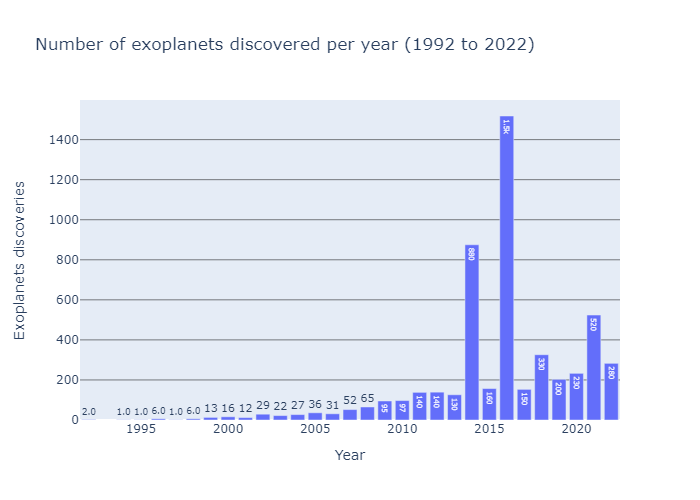

In [430]:
disc_year = df['disc_year'].value_counts()

plot_counts(
    disc_year, 
    x_label='Year', 
    y_label='Exoplanets discoveries',
    title='Number of exoplanets discovered per year (1992 to 2022)'
    )

The number of exoplanets discovered each year follows an upward trend, but the years **2014 and 2016 seem to have been particularly prolific** for the discovery of exoplanets.

Let's take a look at each of these two years to see if one or more telescopes stood out from the crowd.

### Telescopes

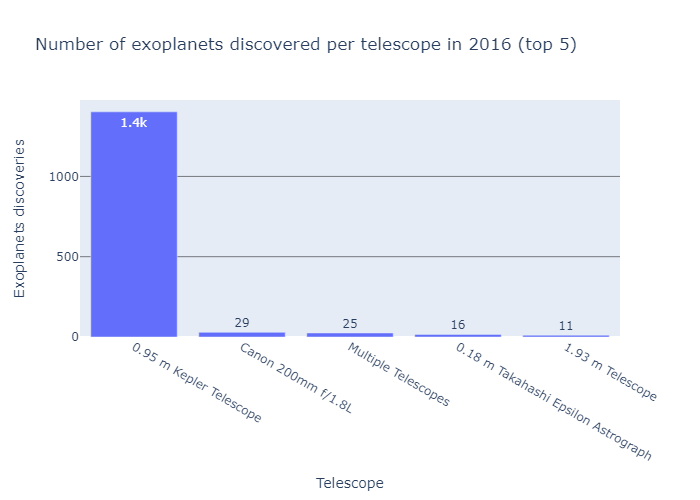

In [431]:
# 2016 telescopes analysis
y_2016 = df.loc[df['disc_year'] == 2016]
y_2016 = y_2016['disc_telescope'].value_counts()

plot_counts(
    y_2016,
    to=5, 
    x_label='Telescope', 
    y_label='Exoplanets discoveries',
    title='Number of exoplanets discovered per telescope in 2016 (top 5)'
    )

The graph clearly shows us that during 2016, **the Kepler telescope was behind almost all exoplanet discoveries**. Let's quickly see if this is also the case for the year 2014

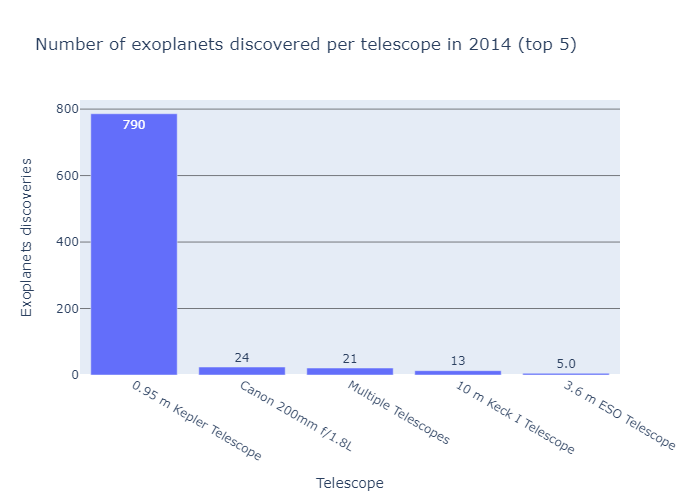

In [432]:
y_2014 = df.loc[df['disc_year'] == 2014]
y_2014 = y_2014['disc_telescope'].value_counts()

plot_counts(
    y_2014,
    to=5, 
    x_label='Telescope', 
    y_label='Exoplanets discoveries',
    title='Number of exoplanets discovered per telescope in 2014 (top 5)'
    )

Also during 2014, the Kepler telescope stood out atop its 786 exoplanets discovered, only 24 for the second place finisher.

Based only on the years 2014 and 2016, **Kepler seems to represent a major asset to the detection of exoplanets**, to confirm this, it would be interesting to measure its overall contribution.

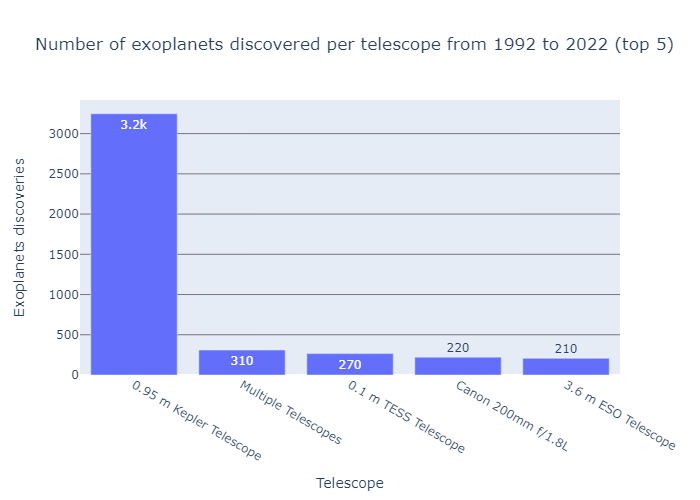

In [433]:
telesc = df['disc_telescope'].value_counts()

plot_counts(
    telesc,
    to=5, 
    x_label='Telescope', 
    y_label='Exoplanets discoveries',
    title='Number of exoplanets discovered per telescope from 1992 to 2022 (top 5)'
    )

Here again, the result is clear, **the Kepler space telescope is a major player in the search for exoplanets**, it has discovered 3247 of the 5187 listed in this dataset, i.e a little more than 62% (almost 2/3 !)

#### Kepler

**A brief history of Kepler** :

The Kepler space telescope, launched in 2009, was designed by NASA with the specific goal of discovering exoplanets by transit method. Its tremendous contribution to this field of research is all the more incredible given its chaotic lifespan :

- **2009** : **detections have been made more difficult** due to the noise generated by the telescope electronics, which turned out to be more important than expected, and by the luminosities of stars which are much more variable than anticipated, complicating the interpretation of the light curves. 
- **2010** : One of the detection modules fails without hope of being repaired, resulting in a **5% decrease in the field of view**
- **2012** : One of the 4 reaction wheels used to orient the telescope does not work anymore, the telescope which needs at least 3 wheels, is in critical situation
- **2013** : One of the 3 remaining wheels breaks down, the telescope is now obliged to use its ergol to orient itself which **does not allow to reach the same precision of pointing**
- **2014** : The telescope cannot maintain permanently its orientation. It uses the photonic thrust to compensate the two missing wheels, but this artifice imposes to frequently modify the observed region of space so that the radiations do not penetrate the telescope aperture. Because of these regular changes of axis, the **telescope can now only identify planets with a very short orbital period**.
- **2018** : After having used all the ergol to maintain its orientations, the reserve was exhausted. **The telescope can no longer ensure its mission**.

It is despite this particularly turbulent life that Kepler was able to discover more than half of the exoplanets listed

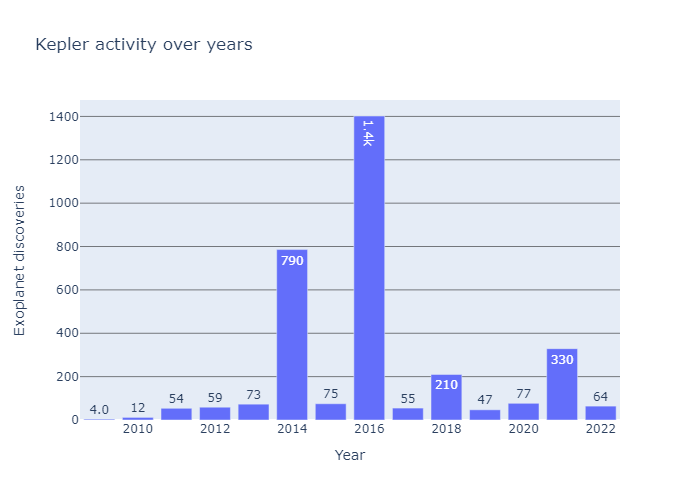

In [445]:
kepler = df.loc[df['disc_telescope'] == '0.95 m Kepler Telescope']
kepler = kepler['disc_year'].value_counts()

plot_counts(kepler, 
x_label='Year', 
y_label='Exoplanet discoveries',
title='Kepler activity over years'
)

These repeated technical problems could partly explain its very heterogeneous level of activity over the years (figure above).

But it should be noted that a **discovery made in a given year does not mean that the telescope photograph also dates from that same year**. Indeed, telescopes can send a large mass of information that can take time to analyze, sometimes several years. This is the reason why Kepler continues to "discover" exoplanets after 2018, the year of its end of service.

#### TESS

TESS is a new space telescope launched in 2018 by NASA and also designed to detect exoplanets and despite its smaller size than Kepler, less efficient detectors and its relative youth, it is already the third largest discoverer of exoplanets

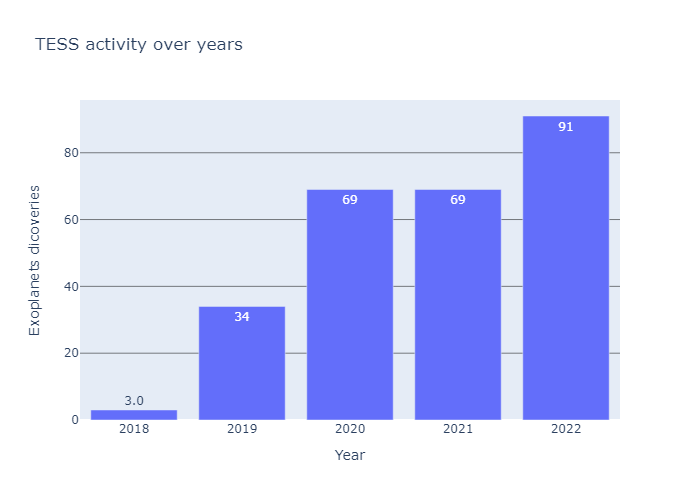

In [448]:
tess = df.loc[df['disc_telescope'] == '0.1 m TESS Telescope']
tess = tess['disc_year'].value_counts()

plot_counts(tess,
x_label='Year',
y_label='Exoplanets dicoveries',
title='TESS activity over years')

In [436]:
test = df.loc[df['sy_dist'] <= 4.6].sort_values('sy_dist')
test[[
    'pl_name',
    'st_mass', 
    'pl_bmasse', 
    'pl_insol',
    'pl_ratdor', 
    'sy_dist'
    ]]

,pl_name,st_mass,pl_bmasse,pl_insol,pl_ratdor,sy_dist
4696,Proxima Cen b,0.12,1.27000,0.65,NaN,1.30119
5152,eps Eri b,0.82,209.76675,NaN,NaN,3.20260
284,GJ 887 b,0.49,4.20000,7.95,NaN,3.29000
285,GJ 887 c,0.49,7.60000,2.56,NaN,3.29000
4710,Ross 128 b,0.17,1.40000,1.38,NaN,3.37454
185,GJ 15 A b,0.38,3.03000,NaN,NaN,3.56228
186,GJ 15 A c,0.38,36.00000,NaN,NaN,3.56228
5178,tau Cet f,0.78,3.93000,NaN,NaN,3.60304
5177,tau Cet e,0.78,3.93000,NaN,NaN,3.60304
5179,tau Cet g,0.78,1.75000,NaN,NaN,3.60304


In [437]:
df.loc[df['pl_name'].str[:3].isin(['KOI']), 'pl_name']

1800       KOI-12 b
1801     KOI-1257 b
1802       KOI-13 b
1803      KOI-142 b
1804      KOI-142 c
1805    KOI-1599.01
1806    KOI-1599.02
1807    KOI-1783.01
1808    KOI-1783.02
1809     KOI-1831 d
1810     KOI-1833 d
1811      KOI-217 b
1812     KOI-3503 b
1813     KOI-3503 c
1814      KOI-351 b
1815      KOI-351 c
1816      KOI-351 d
1817      KOI-351 e
1818      KOI-351 f
1819      KOI-351 g
1820      KOI-351 h
1821     KOI-3680 b
1822    KOI-4777.01
1823       KOI-55 b
1824       KOI-55 c
1825     KOI-7368 b
1826     KOI-7913 b
1827       KOI-94 b
1828       KOI-94 c
1829       KOI-94 d
1830       KOI-94 e
1831      KOI-984 b
1832      KOI-984 c
Name: pl_name, dtype: object